# Instrumentation Design 1
## Lab 5 - DC-Circuits Theorems, Part 1

Lab report by Matt Rixman

### 1. Solving circuits using mesh currents

Objective 1: To learn what is meant by a linear circuit

Objective 2: To verify experimentally the currents calculated by the mesh current method

1-4.  The following resistors were arranged according to Figure 1.4. The power supply was set at 10V each resistor's voltage drop was measured.

In [1]:
# nothing to see here
import pandas as pd
from si_prefix import si_format
from IPython.display import display
from sympy import symbols, Eq

def display_frame(frame):
    display(frame.applymap(lambda x: si_format(x, precision=2)))

r1, r2, r3, r4, r5, r6, rload = symbols('R_1 R_2 R_3 R_4 R_5 R_6 R_load')

circuit = pd.DataFrame.from_dict({
    r1: [1000, 5.62],
    r2: [1000, 4.11],
    r3: [1000, 1.54],
    r4: [1000, 1.03],
    r5: [1000, 0.51],
    r6: [1000, 1.53],
    rload: [1000, 0.51]
}, orient='index', columns=["ohms", "volts"])
display_frame(circuit)

,ohms,volts
R_1,1.00 k,5.62
R_2,1.00 k,4.11
R_3,1.00 k,1.54
R_4,1.00 k,1.03
R_5,1.00 k,510.00 m
R_6,1.00 k,1.53
R_load,1.00 k,510.00 m


5. From these voltages we can determine the currents through each resistor

In [2]:
circuit['amps'] = circuit.apply(lambda x: x["volts"]/x["ohms"], axis=1)
display_frame(circuit)

,ohms,volts,amps
R_1,1.00 k,5.62,5.62 m
R_2,1.00 k,4.11,4.11 m
R_3,1.00 k,1.54,1.54 m
R_4,1.00 k,1.03,1.03 m
R_5,1.00 k,510.00 m,510.00 µ
R_6,1.00 k,1.53,1.53 m
R_load,1.00 k,510.00 m,510.00 µ


6. Before we calculate the mesh currents, let's name some points so that directionality is easy to talk about

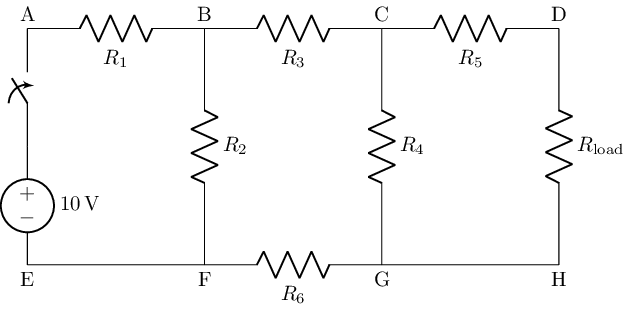

In [3]:
from lcapy import Circuit
Circuit("""
V 1 6 {10}; down
SW 1 2 no; up
R1 2 3; right=1.5
R3 3 4; right=1.5
R5 4 5; right=1.5
W 6 7; right
R6 7 8; right
W 8 9; right
Rload 9 5; up
R2 3 7; down
R4 4 8; down
A1 2; l=A, anchor=south
A2 3; l=B, anchor=south
A3 4; l=C, anchor=south
A4 5; l=D, anchor=south
A6 6; l=E, anchor=north
A7 7; l=F, anchor=north
A8 8; l=G, anchor=north
A9 9; l=H, anchor=north
""").draw(label_ids=False, draw_nodes=False, label_nodes=False)

# lookups for mapping betwee resistors and their segments
vea, vab, vbc, vcd, vdh, vgf, vbf, vcg, vdh = \
    symbols('V_ea V_ab V_bc V_cd V_dh V_gf V_bf V_cg V_dh')
r2v = {
    r1 : vab,
    r2 : vbf,
    r3 : vbc,
    r4 : vcg,
    r5 : vcd,
    r6 : vgf,
    rload: vdh
}
v2r = { v: k for k, v in r2v.items() }

Ohms law gives the voltage of each segment interms of the three mesh currents I<sub>left</sub>, I<sub>center</sub>, and I<sub>right</sub>.

In [4]:
from sympy import symbols, Eq         # used for algebra
from sympy.solvers import solve
ileft, icenter, iright = symbols('I_left, I_center, I_right')

segments = {
    vea : +10,
    vab : r1 * (-ileft),
    vbf : r2 * (-ileft + icenter),
    vbc : r3 * (-icenter),
    vcg : r4 * (-icenter + iright),
    vgf : r6 * (-icenter),
    vcd : r5 * (-iright),
    vdh : rload * (-iright)
}

segment_eq = {}
for segment, formula in segments.items():
    eq = Eq(segment, formula)
    display(eq)
    segment_eq[segment] = eq

Then we write equations for those mesh currents in terms of the voltage deltas.

In [5]:
# if the mesh current travels the opposite way, negate
segments[-vbf] = -1 * segments[vbf]
segments[-vcg] = -1 * segments[vcg]

mesh_paths = {
    ileft : [vea, vab, vbf],         # clockwise from E
    icenter: [-vbf, vbc, vcg, vgf],  # clockwise from F
    iright: [-vcg, vcd, vdh]         # clockwise from G
}

mesh_equation = {}
for current, path in mesh_paths.items():
    eq = Eq(current, sum(map(lambda segment: segments[segment], path)))
    display(eq)
    mesh_equation[current] = eq

And we solve the system

In [6]:
# also equate each resistor with its resistance (so we get numbers and not expressions)
resistor_symbols = [r1, r2, r3, r4, r5, r6, rload]
resistor_substitutions = map(lambda r: Eq(r, circuit["ohms"][r]), resistor_symbols)

# then solve the system of equations
solution = solve(list(mesh_equation.values()) \
                 + list(resistor_substitutions))[0]

# gather mesh currents
mesh_amps = { k : float(v) for k,v in solution.items() if k not in resistor_symbols }
pd.DataFrame.from_dict(
    {
        str(k): [si_format(v, precision=2)] for k,v in mesh_amps.items()
    }, orient="index", columns=["amps"])

,amps
I_center,1.58 m
I_left,5.79 m
I_right,525.65 µ


7-8 Using these values, we can calculate the voltage in each resistor

In [7]:
voltage_symbols = [vab, vbc, vcd, vdh, vgf, vbf, vcg, vdh]
subs = mesh_amps.copy()
subs.update({ r: circuit["ohms"][r] for r in resistor_symbols })
voltages = { v2r[symb]: abs(segments[symb].evalf(subs=subs)) for symb in voltage_symbols }
circuit['volts_calculated'] = circuit.apply(lambda x: voltages[x.name], axis=1)
display_frame(circuit)

,ohms,volts,amps,volts_calculated
R_1,1.00 k,5.62,5.62 m,5.79
R_2,1.00 k,4.11,4.11 m,4.21
R_3,1.00 k,1.54,1.54 m,1.58
R_4,1.00 k,1.03,1.03 m,1.05
R_5,1.00 k,510.00 m,510.00 µ,525.65 m
R_6,1.00 k,1.53,1.53 m,1.58
R_load,1.00 k,510.00 m,510.00 µ,525.65 m


From there, we can get the amps through each resistor  (adding the mesh currents would've worked too, but the data was handy to do it this way...)

In [8]:
circuit['amps_calculated'] = circuit.apply(lambda x: x["volts_calculated"]/x["ohms"], axis=1)
display_frame(circuit)

,ohms,volts,amps,volts_calculated,amps_calculated
R_1,1.00 k,5.62,5.62 m,5.79,5.79 m
R_2,1.00 k,4.11,4.11 m,4.21,4.21 m
R_3,1.00 k,1.54,1.54 m,1.58,1.58 m
R_4,1.00 k,1.03,1.03 m,1.05,1.05 m
R_5,1.00 k,510.00 m,510.00 µ,525.65 m,525.65 µ
R_6,1.00 k,1.53,1.53 m,1.58,1.58 m
R_load,1.00 k,510.00 m,510.00 µ,525.65 m,525.65 µ
